In [19]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as k
import numpy as np
import tensorflow_datasets as tfds
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Lambda, BatchNormalization
from tensorflow.keras.layers import Flatten, Embedding, PReLU, Activation 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist


# Load and Normalize data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [4]:
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

y_train_one_hot=to_categorical(y_train)
y_test_one_hot=to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(y_train_one_hot.shape)

(60000, 28, 28, 1)
(60000,)
(60000, 10)


# Build Model

In [5]:
inputs = Input((28,28,1))
x = Conv2D(32, (3,3))(inputs)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Conv2D(32, (3,3))(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Conv2D(64, (5,5))(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Conv2D(64, (5,5))(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Conv2D(128, (7,7))(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Conv2D(128, (7,7))(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Flatten()(x)
x = Dense(2)(x)
out1 = PReLU(name='out1')(x)
out2 = Dense(10, activation='softmax')(out1)
model = Model(inputs, out2)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
p_re_lu (PReLU)              (None, 26, 26, 32)        21632     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 24, 24, 32)        18432 

# Create CenterLoss

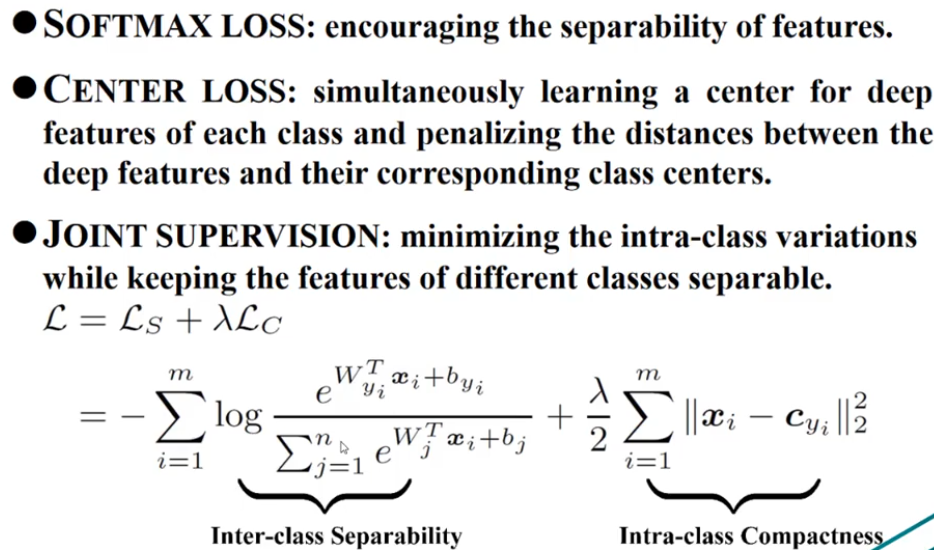

In [6]:
lambda_control = 2
input_ = Input(shape = (1,))
centers = Embedding(10, 2)(input_)
intra_loss = Lambda(lambda x: k.sum(k.square(x[0]-x[1][:,0]),axis = 1, keepdims = True))([out1,centers])

In [7]:
model_center_loss = Model([inputs,input_], [out2,intra_loss])
## the loss calc occurs above , so use a dummy lambda function ((lambda y_true,y_pred:y_pred)) for the loss
model_center_loss.compile(optimizer='sgd', loss=['categorical_crossentropy', lambda y_true,y_pred:y_pred],
                         loss_weights=[1, lambda_control/2.],
                         metrics = ['acc'] )

In [8]:
model_center_loss.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 26, 26, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 26, 26, 32)   21632       batch_normalization[0][0]        
____________________________________________________________________________________________

In [9]:
dummy_matrix1=np.zeros((x_train.shape[0],1))
dummy_matrix2=np.zeros((x_test.shape[0],1))

In [10]:
dummy_matrix1.shape

(60000, 1)

In [11]:
y_train.shape

(60000,)

In [12]:
model_center_loss.fit(x = [x_train,y_train], y = [y_train_one_hot,dummy_matrix1],
                     batch_size = 64, epochs = 2, verbose = 1, validation_data =([x_test,y_test],[y_test_one_hot,dummy_matrix2]),
                     callbacks = [EarlyStopping(monitor="val_loss",patience=20)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 685s 11ms/sample - loss: 2.2842 - dense_1_loss: 2.2686 - lambda_loss: 0.0156 - dense_1_acc: 0.2196 - lambda_acc: 0.9958 - val_loss: 2.2362 - val_dense_1_loss: 2.1572 - val_lambda_loss: 0.0789 - val_dense_1_acc: 0.2813 - val_lambda_acc: 0.9565
Epoch 2/2
60000/60000 [==============================] - 651s 11ms/sample - loss: 2.1174 - dense_1_loss: 2.0617 - lambda_loss: 0.0557 - dense_1_acc: 0.3354 - lambda_acc: 0.9934 - val_loss: 1.9855 - val_dense_1_loss: 1.9197 - val_lambda_loss: 0.0658 - val_dense_1_acc: 0.3615 - val_lambda_acc: 0.9965


# Evaluate Model on the test dataset

In [13]:
func = k.function([model.input],[model.get_layer('out1').output])
test_features = func([x_test])
print(test_features[0].shape)


(10000, 2)


In [14]:
#calculate center of data
test_centers = np.dot(np.transpose(y_test_one_hot), test_features[0])
test_centers_count = np.sum (np.transpose(y_test_one_hot), axis=1, keepdims=True )
test_centers /= test_centers_count
print(test_centers.shape)

(10, 2)


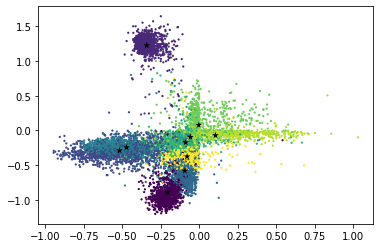

In [15]:
plt.scatter(test_features[0][:,0], test_features[0][:,1], c=y_test, edgecolor="none",s=5)
plt.scatter(test_centers[:,0] ,test_centers[:,1], c="black", marker="*", edgecolor="none", s=50)

# Test Model on the Fashion MNIST dataset

In [16]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
    sqrt = k.sqrt(k.maximum(sum_square, k.epsilon()))
    return sqrt

In [65]:
(f_x_train, f_y_train), (f_x_test, f_y_test)= tf.keras.datasets.fashion_mnist.load_data()
f_x_train = f_x_train.astype('float32')
f_x_test = f_x_test.astype('float32')
f_x_train /= 255
f_x_test /= 255

In [76]:
num_classes = max(f_y_train) + 1
digit_indices = [np.where(f_y_train == i)[0] for i in range(num_classes)]

f_idx = random.randint(0, num_classes-1)
pair1 = f_x_train[random.choice(digit_indices[f_idx])]
pair2 = f_x_train[random.choice(digit_indices[f_idx])]

(28, 28)


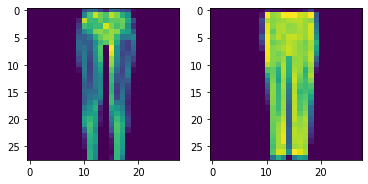

In [77]:
# plot pairs
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(pair1)

plt.subplot(1, 2, 2)
plt.imshow(pair2)


print(pair1.shape)

In [78]:
input1 = np.expand_dims(pair1,[0,3])
input2 = np.expand_dims(pair2,[0,3])
print(input1.shape)

(1, 28, 28, 1)


In [79]:
#make prediction
vec1 = func([input1])
vec2 = func([input2])

In [80]:
distance = euclidean_distance([vec1[0], vec2[0]])
threshold = 1.18
is_same = distance.numpy()[0] < threshold
print(is_same)
print('distance:',distance.numpy()[0])

[ True]
distance: [0.11033696]
